In [2]:
import numpy as np

from triqs.gf import *

from triqs.operators import *
from triqs.operators.util.hamiltonians import h_int_kanamori, h_int_slater
from triqs.operators.util import *
from triqs.operators.util.hamiltonians import *
from triqs.atom_diag import *

from itertools import product

from triqs.plot.mpl_interface import oplot, plt

from scipy.integrate import trapz

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

In [60]:
class GWA:
    def __init__(self, t=1.0, U=4.0, eps=1.0, eta = 0.1, beta = 100, frequency_cutoff = 100):
        self.t = t
        self.U = U
        self.eps = eps
        self.eta = eta
        self.beta = beta
        self.frequency_cutoff = frequency_cutoff
        
        self.N = int(np.ceil((self.beta * self.frequency_cutoff / np.pi - 1) / 2))

        
        self.w_mesh = MeshImFreq(beta = self.beta, S = 'Fermion', n_max = self.N)
        
        
        self.g_up = Gf(mesh = self.w_mesh, target_shape=[2, 2])
        self.g_dn = Gf(mesh = self.w_mesh, target_shape=[2, 2])

        self.gf_struct = [('up', 2), ('dn', 2)]

        self.GfTemplate = BlockGf(mesh = self.w_mesh, gf_struct = self.gf_struct)
        self.w_mesh_values = np.array(list(self.GfTemplate['up'].mesh.values()))
        
        
        self.idm = self.GfTemplate.copy()
        
        for name, g in self.idm:
            self.idm[name].data[:] = np.eye(2)
            
        

        self.G0 = self.exactGreenFunction(interactions = False)
        self.v = self.coulombPotential(self.U)
        self.vH = self.hatreePotential(self.v, self.G0)


    def exactGreenFunction(self, interactions = True):
        if interactions:
            U = self.U
        else:
            U = 0.0
        
        c = np.sqrt(16 * self.t ** 2 + U ** 2)
        a = np.sqrt(2 * (16 * self.t ** 2 / (c - U) ** 2 + 1))
        b = np.sqrt(2 * (16 * self.t ** 2 / (c + U) ** 2 + 1))

        def greenUp(i, j):
            return (-1) ** (i - j) * (inverse(iOmega_n - (self.eps + self.t) ) +
                                       (-1) ** (i - j) * inverse(iOmega_n - (self.eps - self.t))) / 2

        def greenDn(i, j):
            return (-1) ** (i - j) * (inverse(iOmega_n - (self.eps + self.t)) +
                                       inverse(iOmega_n - (self.eps + self.t + U))) / 4 \
                   + ((1 + 4 * self.t / (c - U)) ** 2 / a ** 2) * inverse(
                iOmega_n - (self.eps + self.t - (c - U) / 2)) \
                      + (1 - 4 * self.t / (c + self.U)) ** 2 / b ** 2 * inverse(
                iOmega_n - (self.eps + self.t + (c + U) / 2)) / 2
        
        Gf = self.GfTemplate.copy()

        indices = (0, 1)
        for i, j in product(indices, indices):
            Gf['up'][i, j] << greenUp(i, j)
            Gf['dn'][i, j] << greenDn(i, j)
        return Gf
    
    def exactGW(self):
        h2 = 4 * self.t ** 2 + 2 * self.U * self.t   
        h = np.sqrt(h2)


        A = np.sqrt((2 * self.t + h) ** 2 + 2 * self.U ** 2 * self.t / h)
        B = np.sqrt((-2 * self.t + h - self.U / 2) ** 2 + 2 * self.U ** 2 * self.t / h)
        C = np.sqrt((2 * self.t + h - self.U / 2) ** 2 + 2 * self.U ** 2 * self.t / h)

        w1_p = (2 * self.eps - h + A) / 2
        w1_m = (2 * self.eps - h - A) / 2

        w2_p = (2 * self.eps + h + A) / 2
        w2_m = (2 * self.eps + h - A) / 2
        
        w3_p = (2 * self.eps + h + self.U / 2 + B / 2)
        w3_m = (2 * self.eps + h + self.U / 2 - B / 2)

        w4_p = (2 * self.eps + h + self.U / 2 + C / 2)
        w4_m = (2 * self.eps + h + self.U / 2 - C / 2)

        def GWUp(i, j):
            return (-1) ** (i - j) * ((1 / 4 + (2 * self.t + h) / (4 * A)) * inverse(iOmega_n - w1_p) + (1 / 4 - (2 * self.t + h) / (4 * A)) * inverse(iOmega_n - w1_m)) \
                    + (1 / 4 - (2 * self.t + h) / (4 * A)) * inverse(iOmega_n - w2_p) + (1 / 4 + (2 * self.t + h) / (4 * A)) * inverse(iOmega_n - w2_m)

        def GWDn(i, j):
            return (-1) ** (i - j) * ((1 / 4 + (2 * self.t - h + self.U / 2) / (4 * B)) * inverse(iOmega_n - w3_p) + (1 / 4 - (2 * self.t - h + self.U / 2) / (4 * B)) * inverse(iOmega_n - w3_m)) \
                    + (1 / 4 - (2 * self.t + h - self.U / 2) / (4 * C)) * inverse(iOmega_n - w4_p) + (1 / 4 + (2 * self.t + h - self.U / 2) / (4 * C)) * inverse(iOmega_n - w4_m)
        
        Gf = self.GfTemplate.copy()

        indices = (0, 1)
        for i, j in product(indices, indices):
            Gf['up'][i, j] << GWUp(i, j)
            Gf['dn'][i, j] << GWDn(i, j)
        return Gf
    
    
    def coulombPotential(self, U):
        v = self.GfTemplate.copy()
        for name, g in v:
            v[name].data[:] = np.eye(2) * U
        return v

    def polarization(self, G):
        
        G = make_gf_from_fourier(G)
        P = make_gf_from_fourier(self.GfTemplate).copy()

        for name, g in P:
            P[name].data[:] = G[name].transpose().data[::-1, :, :] * G[name].data[:]

        return P

    def screenedPotential(self, P, v):
        P = make_gf_from_fourier(P)
        
        P, v, idm = self.onMesh(P, v, self.idm)
        
        return (idm - v * P).inverse() * v

    def selfEnergy(self, G, W):
        G = make_gf_from_fourier(G)
        W = make_gf_from_fourier(W)

        Σ = make_gf_from_fourier(self.GfTemplate).copy()

        for name, g in Σ:
            Σ[name].data[:] =  -G[name].data[:] * W[name].data[:]

        return Σ

    def hatreePotential(self, v, G):
            
        omegas = np.array(list(G['up'].mesh.values()))
        integratedG = self.GfTemplate.copy()
        vH = self.GfTemplate.copy()
        for name, g in integratedG:
            # integratedG[name].data[:] = np.array([[trapz(G[name].data[:, i, j], omegas) for j in range(2)] for i in range(2)])
            integratedG[name].data[:] = np.sum(G[name].data[:, :, :], axis = 0) / self.beta

        # print(np.sum(G['up'].data[:, :, :], axis = 0) / self.beta)
        # print(G['up'].density())
        
        for name, g in G:
            vH[name].data[:] = -v[name].data[:] * integratedG[name].data[:] * 1j

        return vH

    def greenFunction(self, G0, Σ, vH):
        Σ = make_gf_from_fourier(Σ)

        G0, Σ, idm, vH = self.onMesh(G0, Σ, self.idm, vH)

        return (G0.inverse() - (Σ + vH)).inverse()

    def onMesh(*args):
        arglist = []
        for arg in args:
            arglist.append(arg)
        arglist.pop(0)

        if len(arglist) <= 1:
            return arglist[0]
        
        for i, arg in enumerate(arglist[1:]):
            new_arg = arglist[0].copy()
            for name, g in arg:
                new_arg[name].data[:] = arg[name].data[:]
            arglist[i+1] = new_arg
        return arglist
    
    
    def perform_GWA(self, cycles):
        G = self.G0.copy()
        GW = self.G0.copy()
        for i in range(cycles):
            self.P = self.polarization(G)
            self.W = self.screenedPotential(self.P, self.v)
            self.Σ = self.selfEnergy(G, self.W)
            GW = self.greenFunction(G, self.Σ, self.vH)
        return GW


In [106]:
gw = GWA(t = 1.0, U = 4.0, eps = 1.0, eta = 0.1, beta = 100, frequency_cutoff = 1000)
omega = np.imag(gw.w_mesh_values)
G_omega = gw.exactGreenFunction()
GW = gw.perform_GWA(cycles = 1)
GWe = gw.exactGW()
P_tau = gw.P
W_omega = gw.W
Σ_tau = gw.Σ

G_tau = make_gf_from_fourier(G_omega)
P_omega = make_gf_from_fourier(P_tau)
GWetau = make_gf_from_fourier(GWe)

 Error = 0.00657638
 Please make sure you treat the constant offset analytically!
 Error = 0.00657638
 Please make sure you treat the constant offset analytically!


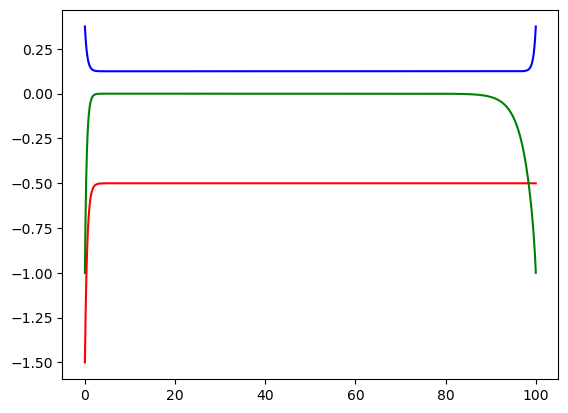

In [107]:
spin = 'up'
f = np.array(list(P_tau['up'].mesh.values()))
# print(f)
plt.plot(f, np.real(np.trace(G_tau[spin].data[:,:,:], axis1=1, axis2=2)), color = 'red')
plt.plot(f, np.real(np.trace(P_tau[spin].data[:,:,:], axis1=1, axis2=2)), color = 'blue')
plt.plot(f, np.real(np.trace(GWetau[spin].data[:,:,:], axis1=1, axis2=2)), color = 'green')
# plt.plot(omega, np.real(np.trace(GW[spin].data[:,:,:], axis1=1, axis2=2)), color = 'blue')
# plt.plot(omega, np.real(np.trace(GWe[spin].data[:,:,:], axis1=1, axis2=2)), color = 'green')
# plt.plot(omega, np.real(np.trace(G_omega[spin].data[:,:,:], axis1=1, axis2=2)), color = 'red') 
# # plt.plot(omega, np.imag(np.trace(GW[spin].data[:,:,:], axis1=1, axis2=2)), color = 'blue') 
# # plt.plot(omega, np.imag(np.trace(GWe[spin].data[:,:,:], axis1=1, axis2=2)), color = 'green')
# plt.xlim(-10, 10)
# plt.ylim(-1, 2)